In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('Dataset\doge_dataset_day_ohlcvm.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Features and target
X = df[['open', 'high', 'low', 'volume_DOGE', 'market_cap', 'volume']]  # You can add more features if available
y = df['close']  # Target variable: closing price

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.0000
R² Score: 0.9962


## Correlation Matrix

In [3]:
print(df[['open', 'close', 'high', 'low', 'volume_DOGE', 'market_cap', 'volume']].corr())

                 open     close      high       low  volume_DOGE  market_cap  \
open         1.000000  0.995383  0.996608  0.996618     0.068783    0.748095   
close        0.995383  1.000000  0.998233  0.996842     0.079557    0.748373   
high         0.996608  0.998233  1.000000  0.994104     0.088358    0.740723   
low          0.996618  0.996842  0.994104  1.000000     0.060686    0.757410   
volume_DOGE  0.068783  0.079557  0.088358  0.060686     1.000000    0.066979   
market_cap   0.748095  0.748373  0.740723  0.757410     0.066979    1.000000   
volume       0.724094  0.727230  0.731679  0.719526     0.219756    0.531926   

               volume  
open         0.724094  
close        0.727230  
high         0.731679  
low          0.719526  
volume_DOGE  0.219756  
market_cap   0.531926  
volume       1.000000  


From the correlation matrix, we can see that market cap and price is correlated. Now there are two options:
- Building a time aware model: Model depend on the past data instead of the derived current values.
- Remove market cap from the features
I will focus more one first option as it could be more realistic

# Building a time-aware model

## Linear Regression, Random Forest, XGBoost


📊 Evaluating models with 1-day lag features:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2929, number of used features: 6
[LightGBM] [Info] Start training from score 0.027435
Linear Regression - MSE: 0.000101, R²: 0.9842
Random Forest - MSE: 0.000724, R²: 0.8873
XGBoost - MSE: 0.001445, R²: 0.7749
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2929, number of used features: 6
[LightGBM] [Info] Start training from score 0.027435
LightGBM - MSE: 0.000504, R²: 0.9215

📊 Evaluating models with 2-day lag features:


C:\Users\miraz\AppData\Local\Temp\ipykernel_21676\101223838.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2928, number of used features: 6
[LightGBM] [Info] Start training from score 0.027444
Linear Regression - MSE: 0.000186, R²: 0.9710
Random Forest - MSE: 0.001724, R²: 0.7313
XGBoost - MSE: 0.001115, R²: 0.8262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2928, number of used features: 6
[LightGBM] [Info] Start training from score 0.027444
LightGBM - MSE: 0.000717, R²: 0.8884

📊 Evaluating models with 3-day lag features:


C:\Users\miraz\AppData\Local\Temp\ipykernel_21676\101223838.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2928, number of used features: 6
[LightGBM] [Info] Start training from score 0.027493
Linear Regression - MSE: 0.000273, R²: 0.9574
Random Forest - MSE: 0.003403, R²: 0.4703
XGBoost - MSE: 0.001804, R²: 0.7192
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2928, number of used features: 6
[LightGBM] [Info] Start training from score 0.027493
LightGBM - MSE: 0.001754, R²: 0.7269

📊 Evaluating models with 4-day lag features:


C:\Users\miraz\AppData\Local\Temp\ipykernel_21676\101223838.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2927, number of used features: 6
[LightGBM] [Info] Start training from score 0.027502
Linear Regression - MSE: 0.000372, R²: 0.9421
Random Forest - MSE: 0.005207, R²: 0.1894
XGBoost - MSE: 0.003077, R²: 0.5210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2927, number of used features: 6
[LightGBM] [Info] Start training from score 0.027502
LightGBM - MSE: 0.003881, R²: 0.3959

📊 Evaluating models with 5-day lag features:


C:\Users\miraz\AppData\Local\Temp\ipykernel_21676\101223838.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2926, number of used features: 6
[LightGBM] [Info] Start training from score 0.027511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\miraz\AppData\Local\Temp\ipykernel_21676\101223838.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2926, number of used features: 6
[LightGBM] [Info] Start training from score 0.027563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\miraz\AppData\Local\Temp\ipykernel_21676\101223838.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2925, number of used features: 6
[LightGBM] [Info] Start training from score 0.027573
Linear Regression - MSE: 0.000646, R²: 0.8995
Random Forest - MSE: 0.006110, R²: 0.0495
XGBoost - MSE: 0.008421, R²: -0.3100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2925, number of used features: 6
[LightGBM] [Info] Start training from score 0.027573
LightGBM - MSE: 0.005790, R²: 0.0993


C:\Users\miraz\AppData\Local\Temp\ipykernel_21676\101223838.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\miraz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\miraz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


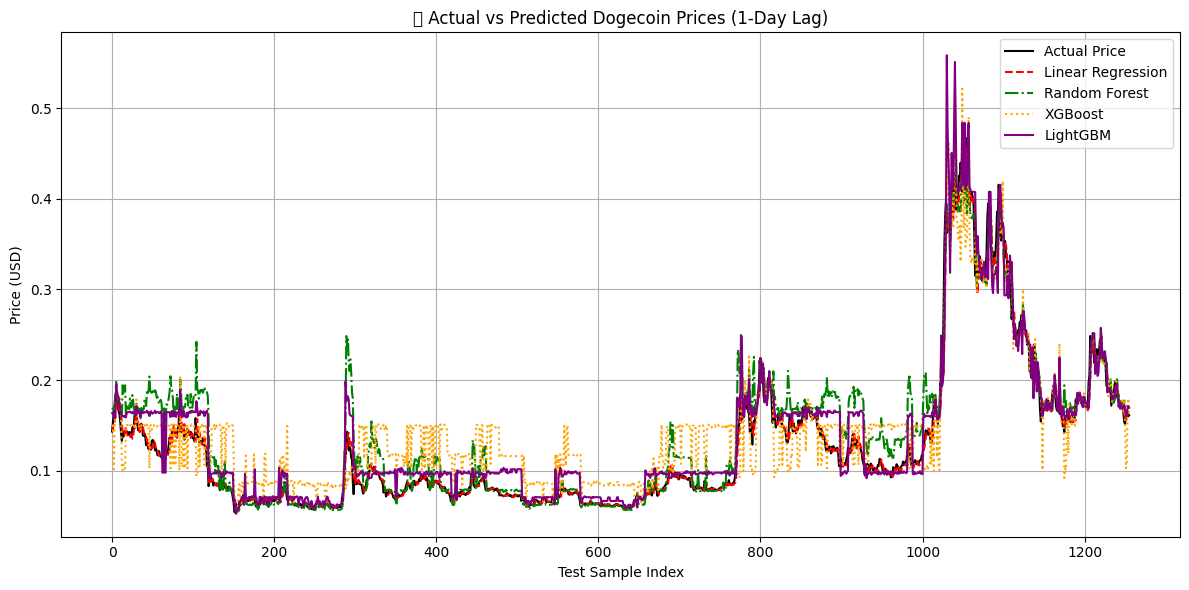

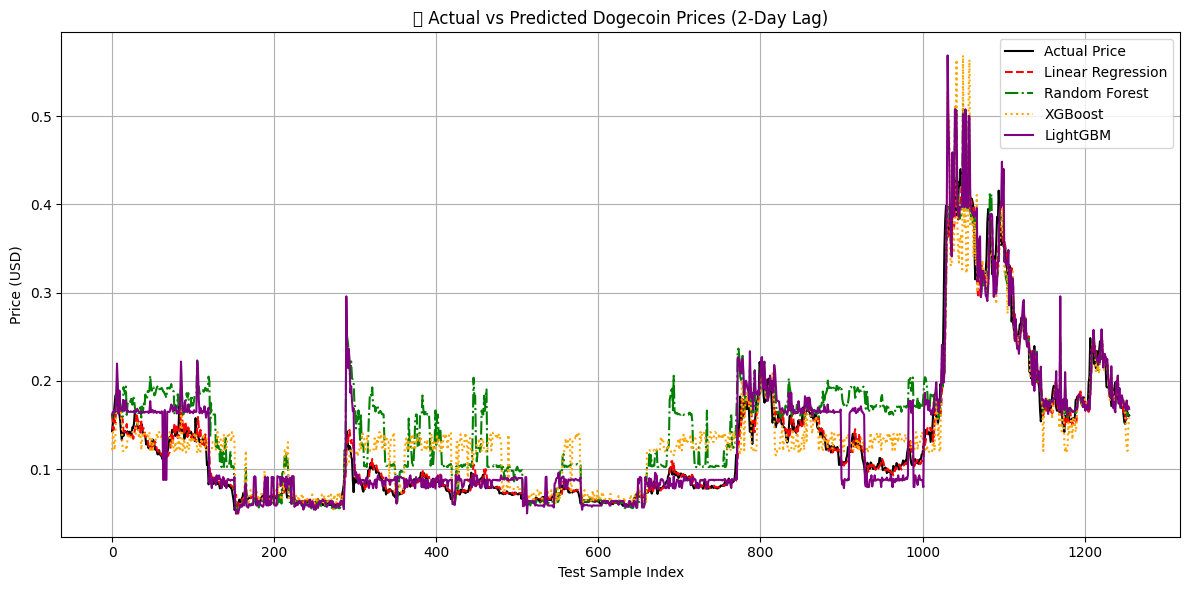

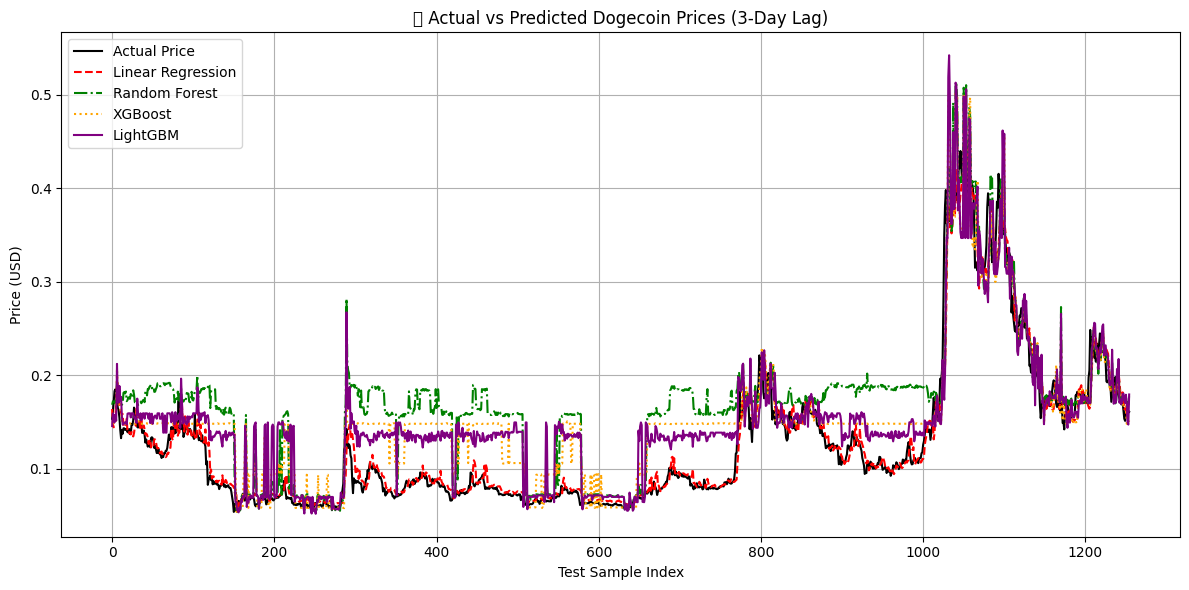

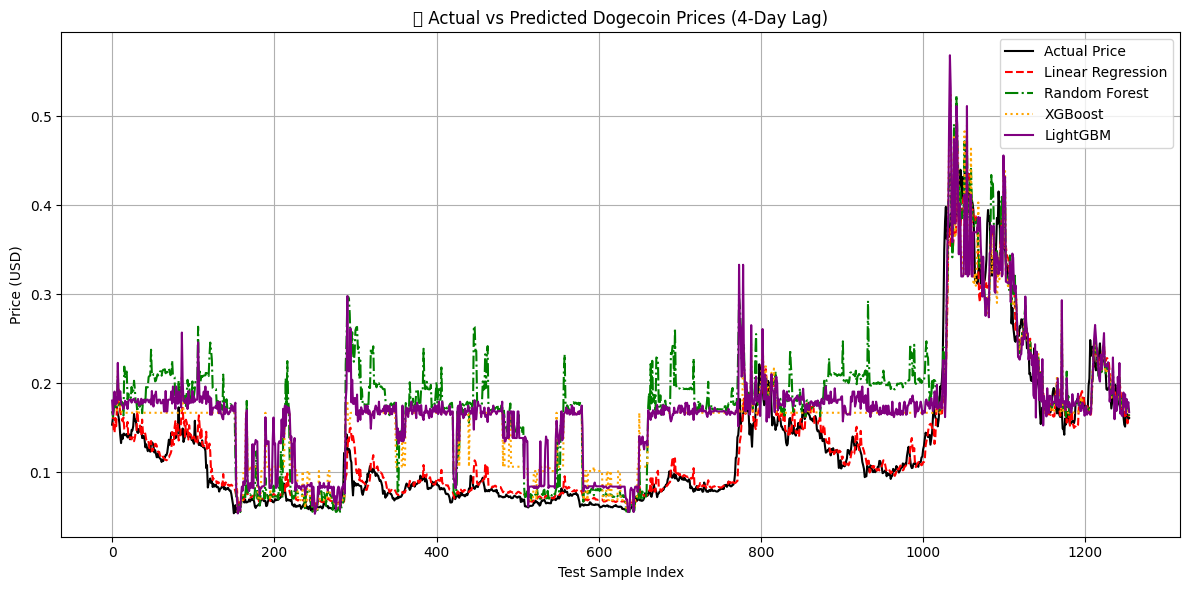

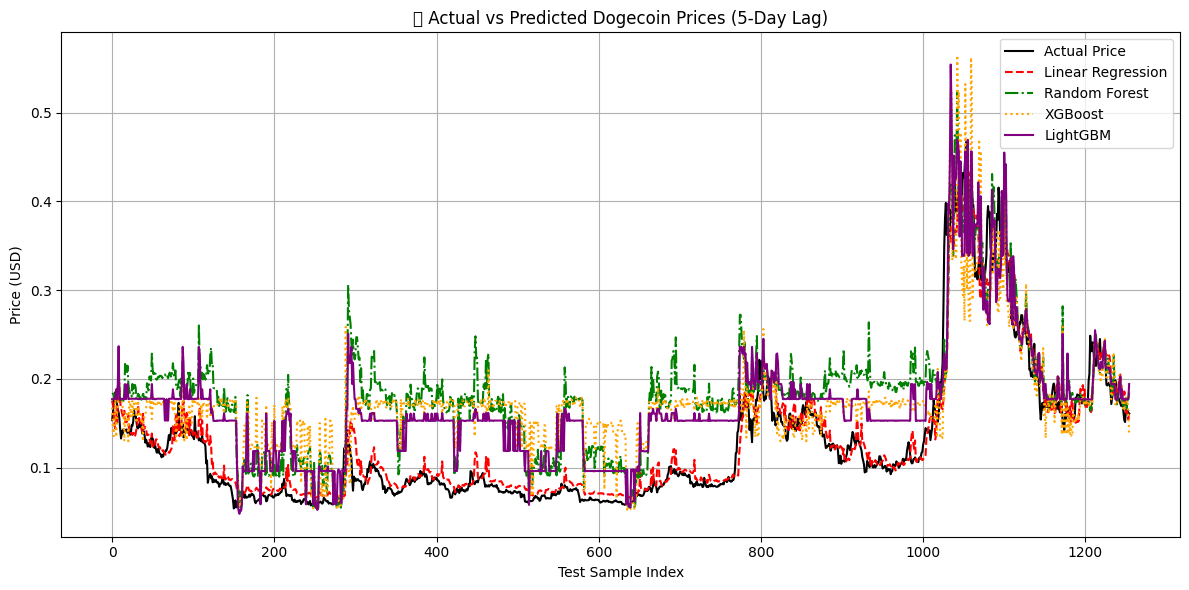

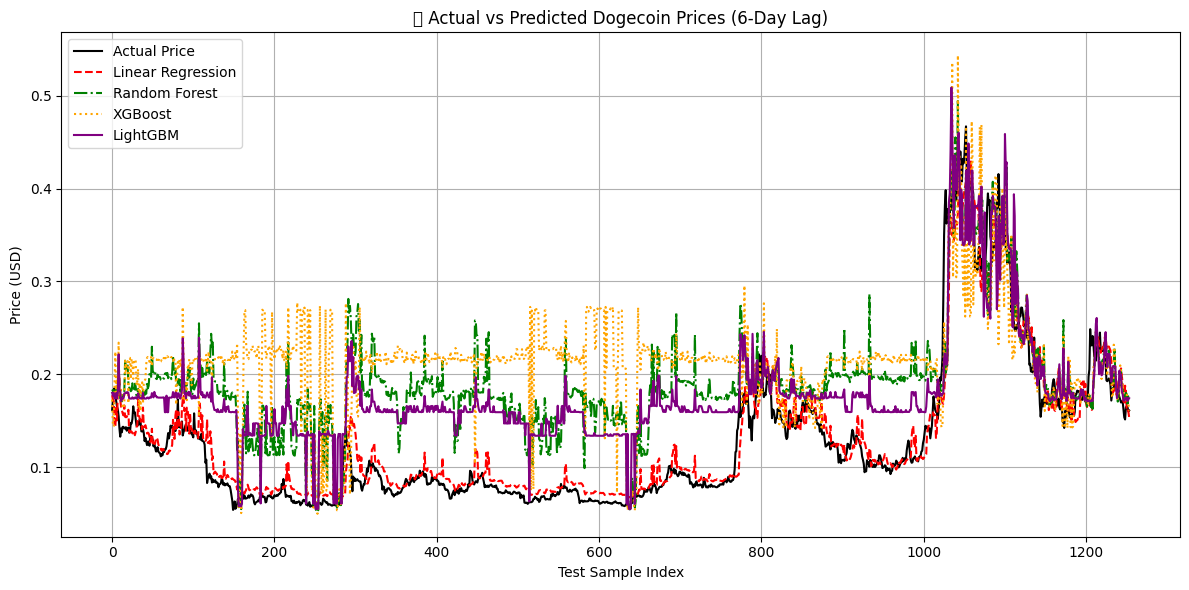

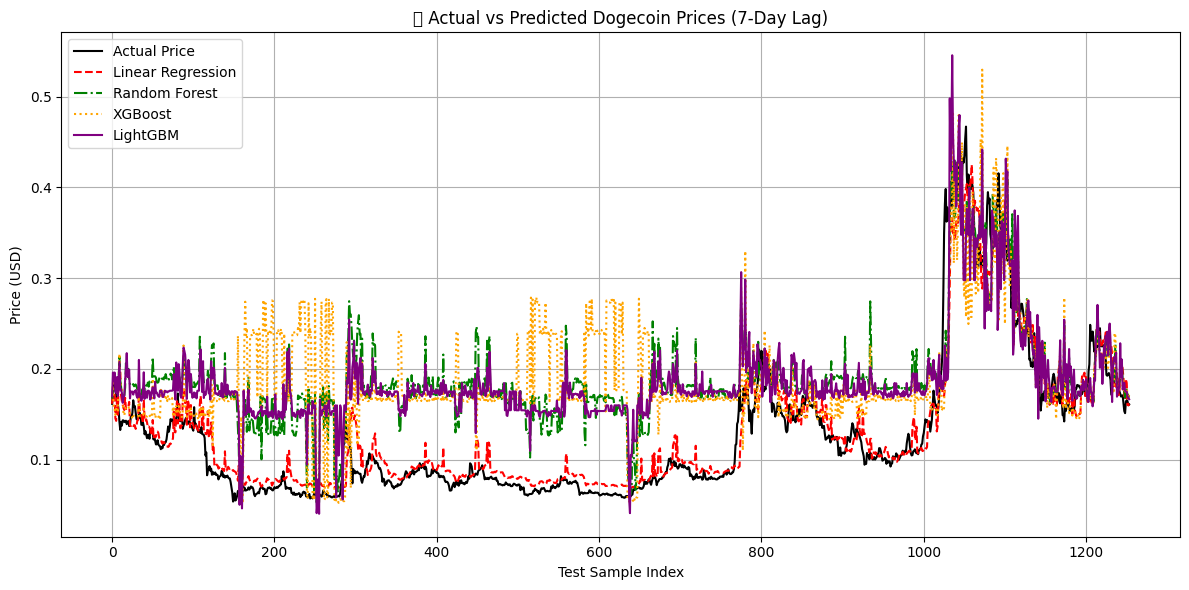

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import lag_features
from src.tuning import tune_random_forest, tune_xgboost, tune_lightgbm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Loop through different lag settings ---
for lag in range(1, 8):
    print(f"\n📊 Evaluating models with {lag}-day lag features:")
    X_train, X_test, y_train, y_test = lag_features.create_lag_features(lag)

    # Tune hyperparameters for Random Forest, XGBoost, and LightGBM
    best_rf, mse_rf, r2_rf = tune_random_forest(X_train, y_train, X_test, y_test)
    best_xgb, mse_xgb, r2_xgb = tune_xgboost(X_train, y_train, X_test, y_test)
    best_lgb, mse_lgb, r2_lgb = tune_lightgbm(X_train, y_train, X_test, y_test)

    # --- Train Models ---
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": best_rf,
        "XGBoost": best_xgb,
        "LightGBM": best_lgb
    }

    predictions = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        predictions[name] = preds
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        print(f"{name} - MSE: {mse:.6f}, R²: {r2:.4f}")

    # --- Plot Predictions ---
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual Price', color='black')

    for name, preds in predictions.items():
        linestyle = {
            "Linear Regression": "--",
            "Random Forest": "-.",
            "XGBoost": ":",
            "LightGBM": "-"
        }[name]
        color = {
            "Linear Regression": "red",
            "Random Forest": "green",
            "XGBoost": "orange",
            "LightGBM": "purple"
        }[name]
        plt.plot(preds, label=name, linestyle=linestyle, color=color)

    plt.title(f'📈 Actual vs Predicted Dogecoin Prices ({lag}-Day Lag)')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.show()


## Tommorrows price

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load & Sort Data
df = pd.read_csv('Dataset/doge_dataset_day_ohlcvm.csv', parse_dates=['date'])
df = df.sort_values('date')

# Step 2: Create Lag Feature for Prediction
last = df.iloc[-1]
X_tomorrow = pd.DataFrame([[
    last['market_cap'], 
    last['volume'], 
    last['volume_DOGE'], 
    last['open'], 
    last['high'], 
    last['low']
]], columns=[
    'market_cap_lag1', 'volume_lag1', 'volume_DOGE_lag1', 
    'open_lag1', 'high_lag1', 'low_lag1'
])

# Step 3: Build Lagged Dataset
df['market_cap_lag1'] = df['market_cap'].shift(1)
df['volume_lag1'] = df['volume'].shift(1)
df['volume_DOGE_lag1'] = df['volume_DOGE'].shift(1)
df['open_lag1'] = df['open'].shift(1)
df['high_lag1'] = df['high'].shift(1)
df['low_lag1'] = df['low'].shift(1)
df.dropna(inplace=True)

# Step 4: Split Data
features = ['market_cap_lag1', 'volume_lag1', 'volume_DOGE_lag1', 
            'open_lag1', 'high_lag1', 'low_lag1']
X = df[features]
y = df['close']
train_size = int(len(df) * 0.7)
X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]

# Step 5: Train All Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_depth=10),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
}

# Step 6: Fit and Predict for Today
print(f"📅 Based on yesterday’s data ({last['date'].date()}),")
for name, model in models.items():
    model.fit(X_train, y_train)
    predicted_price = model.predict(X_tomorrow)[0]
    print(f"🔹 {name} predicted Dogecoin price: ${predicted_price:.6f}")


📅 Based on yesterday’s data (2025-06-27),
🔹 Linear Regression predicted Dogecoin price: $0.157493
🔹 Random Forest predicted Dogecoin price: $0.163134
🔹 XGBoost predicted Dogecoin price: $0.169618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 2929, number of used features: 6
[LightGBM] [Info] Start training from score 0.027435
🔹 LightGBM predicted Dogecoin price: $0.161885
